In [1]:
import pandas as pd
import tarfile
import gzip
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
"""
PATH="./wikispeedia_articles_plaintext.tar.gz"
DEST="./plaintext"

with tarfile.open(PATH,"r:gz") as fichier:
    fichiers_names=fichier.getnames()
    for name in fichiers_names:
        fichier.extract(name, DEST)
"""  
#Normalement pas besoin de relancer (uniquement le grand fichier html n'a pas été dézipé)     

'\nPATH="./wikispeedia_articles_plaintext.tar.gz"\nDEST="./plaintext"\n\nwith tarfile.open(PATH,"r:gz") as fichier:\n    fichiers_names=fichier.getnames()\n    for name in fichiers_names:\n        fichier.extract(name, DEST)\n'

Utilisation des données sur les finished paths

In [6]:
PATH_USER="C:/Users/Adrien/Desktop/MA 1/Applied data analysis/Projet/data" 
PATH=PATH_USER+"/paths-and-graph/wikispeedia_paths-and-graph/paths_finished.tsv"
PATH_UNFINISHED = PATH_USER+"/paths-and-graph/wikispeedia_paths-and-graph/paths_unfinished.tsv"


finished_path=pd.read_csv(PATH, header=14, delimiter="\t", names=["hashedIpAddress","timestamp","durationInSec","path","rating"])
unfinished_path=pd.read_csv(PATH_UNFINISHED, header=16, delimiter="\t", names=["hashedIpAddress","timestamp","durationInSec","path_start","path_goal","rating"])
finished_path["timestamp"]=pd.to_datetime(finished_path["timestamp"], unit ='s') #convertir le timestamp to datetime
unfinished_path["timestamp"]=pd.to_datetime(unfinished_path["timestamp"], unit ='s') #convertir le timestamp to datetime
finished_path.head()
unfinished_path.head()
print(f"Finished paths : First date {finished_path.timestamp.dt.date.min()} \t Last Date {finished_path.timestamp.dt.date.max()} ")
print(f"Unfinished paths : First date {unfinished_path.timestamp.dt.date.min()} \t Last Date {unfinished_path.timestamp.dt.date.max()} ")


Finished paths : First date 2008-08-18 	 Last Date 2014-01-15 
Unfinished paths : First date 2011-02-07 	 Last Date 2014-01-15 


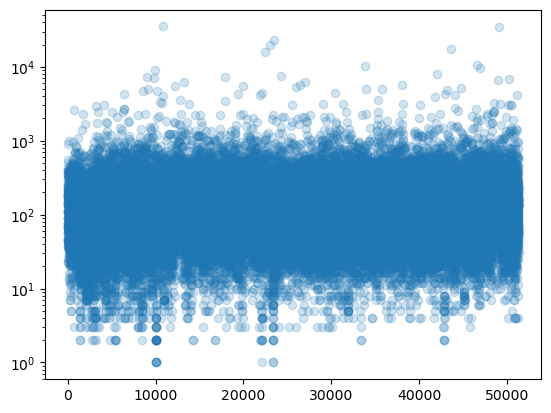

In [7]:
fig,ax=plt.subplots()
fig=plt.scatter(finished_path.index, finished_path["durationInSec"], alpha=0.2)
ax.set_yscale("log")

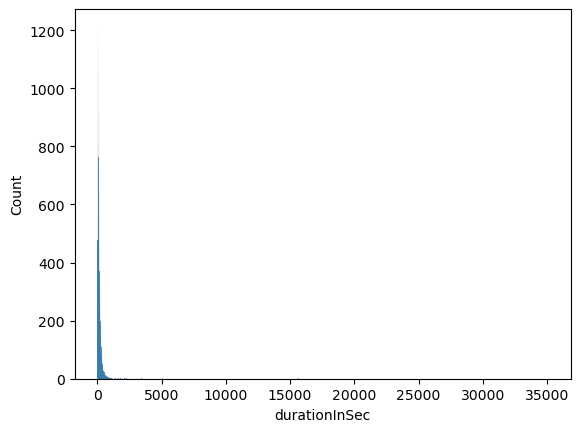

In [8]:
ax=sns.histplot(finished_path["durationInSec"], bins=10000)

Text(0, 0.5, 'Duration [s]')

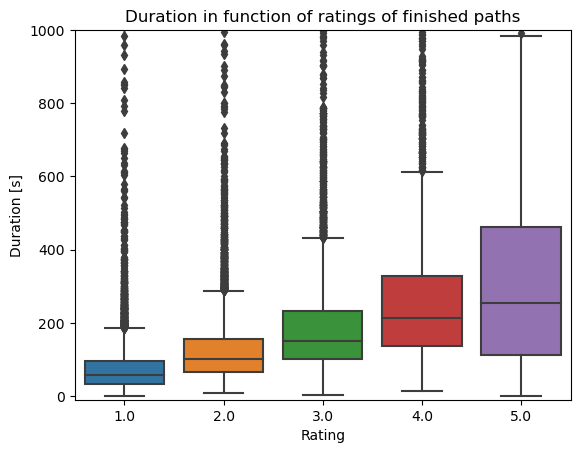

In [9]:

ax=sns.boxplot(x="rating", y="durationInSec", data=finished_path)
ax.set_ylim([-10,1000])
ax.set_title("Duration in function of ratings of finished paths")
ax.set_xlabel("Rating")
ax.set_ylabel("Duration [s]")


In [ ]:
#Juste un essai pour push 